# Using Vader Sentiment Polarity Scores to Correlate to the Dow Jones Index 

In [97]:
from nltk.corpus import wordnet as wn
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
import pandas as pd
import re
from nltk.corpus import sentiwordnet as swn
from nltk import word_tokenize
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import StandardScaler
from finta import TA
import datetime

# nltk.download('stopwords')

In [4]:
def row_polarity(tweet_row):
    '''Input: Tweet from df_test.
    Create new value in either positive or negative column
    Output: Create pandas column score/

    for each tweet in df_test
    get the polarity score
    if positive column = 1 else vice versa
    '''
    #take in tweet return tweet, and polarity scores
    analyzer = SentimentIntensityAnalyzer()
    pols = analyzer.polarity_scores(tweet_row.text)
    if pols['neu'] == 1.0:
        tweet_row['neutral'] = 1
    if pols['pos'] != 0.0 and pols['pos'] > pols['neg']:
        tweet_row['positive'] = 1
    else:
        tweet_row['negative'] = 1
    return tweet_row
    

        


## Preprocessing Tweets

In [5]:
# pickle is from POMS notebook
df_text = pd.read_pickle('./cleaned_tweets.pickle'); df_text.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset update facebook texting might cry result...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many times ball managed save 50 rest go ...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behaving mad see


In [6]:


# # takes many hours
# df = df.apply(row_polarity, axis=1)
# pd.to_pickle(df, './sentiment_tweets.pickle')

# df = df.fillna(0)
# df = df.drop(columns=['flag', 'ids', 'target', 'user']); df.head()

# convert to date time, disregard the time element
# takes a bout 30min to run
# df['date'] = pd.to_datetime(df['date']).dt.date
# pd.to_pickle(df, './final_tweets.pickle')

## Load Pickle 

In [7]:
# load in tweets, that have sentiment scores and parsed dates 
df = pd.read_pickle('./final_tweets.pickle')

In [8]:
# group by the date of tweets and sum - we only want to keep the moods scores and date
df_summed = df.groupby('date', as_index=False).sum()

df_summed.sample(10)

,date,negative,neutral,positive
12,2009-05-10,11508.0,6161.0,14521.0
5,2009-04-20,8735.0,4705.0,9725.0
15,2009-05-14,8475.0,4652.0,8985.0
4,2009-04-19,12972.0,7210.0,14497.0
37,2009-06-15,53203.0,28612.0,56578.0
34,2009-06-06,52925.0,28918.0,58751.0
23,2009-05-26,5107.0,2629.0,5671.0
9,2009-05-03,17023.0,9054.0,18310.0
29,2009-06-01,52805.0,28202.0,57485.0
22,2009-05-25,79.0,45.0,90.0


In [9]:
# get total amount 
df_summed['total_score'] = df_summed.drop(columns=['date']).sum(axis=1).astype(int)
df_summed.head(5)

,date,negative,neutral,positive,total_score
0,2009-04-06,1701.0,868.0,1659.0,4228
1,2009-04-07,8426.0,4551.0,8885.0,21862
2,2009-04-17,1389.0,740.0,1695.0,3824
3,2009-04-18,10321.0,5646.0,11433.0,27400
4,2009-04-19,12972.0,7210.0,14497.0,34679


In [10]:
# compute row average for each mood against the total score for the day
def mood_avg(row):
    return row / df_summed['total_score'][row.name] * 100

df_avg = df_summed.drop(columns=['date']).apply(mood_avg, axis=1)

# remove total score as it is now meaningless
df = df_avg.drop(columns=['total_score'])

### Scaling 

In [11]:
cols = ['positive', 'neutral', 'negative']

scaler = StandardScaler()
df_avg[cols] = scaler.fit_transform(df_avg[cols])
# join scaled numbers back to dates
df = pd.concat([df_summed['date'],df_avg], axis=1)

In [12]:
df.head(3)

,date,negative,neutral,positive,total_score
0,2009-04-06,-0.057990,0.534566,0.001579,100.0
1,2009-04-07,-0.370057,1.036600,0.268420,100.0
2,2009-04-17,-0.779716,-1.525622,0.969153,100.0


### Load processed DF 

In [13]:
df = pd.read_pickle('./tweets_scaled_avg.pickle')

### Dow Jones Data  

In [14]:
# Function source: https://github.com/Crypto-toolbox/pandas-technical-indicators
# class of functions are not python package,
# so I have pasted it here, for accessibility
def average_directional_movement_index(df, n, n_ADX):
    """Calculate the Average Directional Movement Index for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :param n_ADX: 
    :return: pandas.DataFrame
    """
    i = 0
    UpI = []
    DoI = []
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'High'] - df.loc[i, 'High']
        DoMove = df.loc[i, 'Low'] - df.loc[i + 1, 'Low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    i = 0
    TR_l = [0]
    while i < df.index[-1]:
        TR = max(df.loc[i + 1, 'High'], df.loc[i, 'Close']) - min(df.loc[i + 1, 'Low'], df.loc[i, 'Close'])
        TR_l.append(TR)
        i = i + 1
    TR_s = pd.Series(TR_l)
    ATR = pd.Series(TR_s.ewm(span=n, min_periods=n).mean())
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean() / ATR)
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean() / ATR)
    ADX = pd.Series((abs(PosDI - NegDI) / (PosDI + NegDI)).ewm(span=n_ADX, min_periods=n_ADX).mean(),
                    name='ADX_' + str(n) + '_' + str(n_ADX))
    df = df.join(ADX)
    return df


In [114]:
dji_raw = pd.read_csv('./^DJI.csv'); dji_raw.head()
dji_old = dji_raw.copy()

### From the paper
"So,if the DJIA value on a given day is x and the next available data point is y with n days missing in between, We approximate the missing data by estimating the first day after x to be (y+x)/2 and then following the same method recursively till all gaps are filled"



In [115]:
# set Date as index for reindex to work as expected
dji_raw = dji_raw.set_index('Date')

idx = pd.date_range('2009-04-06', '2009-06-24')
# change df to a datetime index
dji_raw.index = pd.DatetimeIndex(dji_raw.index)
# fill 
dji_raw = dji_raw.reindex(idx, fill_value=0)

In [116]:
def fill_weekend(df):
    '''Create columns for weekends, fill in with concave function
    find day before empty date, call it ,y. find next non-empty day,
    call it y. Compute y+x/2 and fill in empty row.
    '''
    date_idxs = df[df['Open'] == 0].index

    for date in date_idxs:
        # get previous days value
        prev_day = df.loc[date - datetime.timedelta(1)]
        # get next non-empty day
        # start two days ahead, check if not check next day
        dates_ahead = df.loc[date + datetime.timedelta(2):]
        # get the next non-empty date 
        next_trading_days = dates_ahead[dates_ahead['Open'] != 0]
        # edge case, if the last day is empty
        if next_trading_days.size == 0:
            continue
        next_trading = next_trading_days.index[0]
        df.loc[date] = (prev_day + df.loc[next_trading]) / 2
    return df
        
dji_raw = fill_weekend(dji_raw)        

In [117]:
dji_raw = dji_raw.reset_index()


In [118]:
dji_raw = dji_raw.rename(columns={'index': 'Date'})

In [119]:
def change_adx(dji_df, n, n_adx):
    dji = average_directional_movement_index(dji_df, n,n_adx)
    num_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', f'ADX_{n}_{n_adx}']
    dji[num_cols] = scaler.fit_transform(dji[num_cols])
    return dji[['Date', f'ADX_{n}_{n_adx}']]
    
dji = change_adx(dji_raw, 4, 4)

In [120]:
dji_old = change_adx(dji_old, 4, 4)

In [121]:
dji['Date'] = pd.to_datetime(dji['Date'])
dji_old['Date'] = pd.to_datetime(dji_old['Date'])

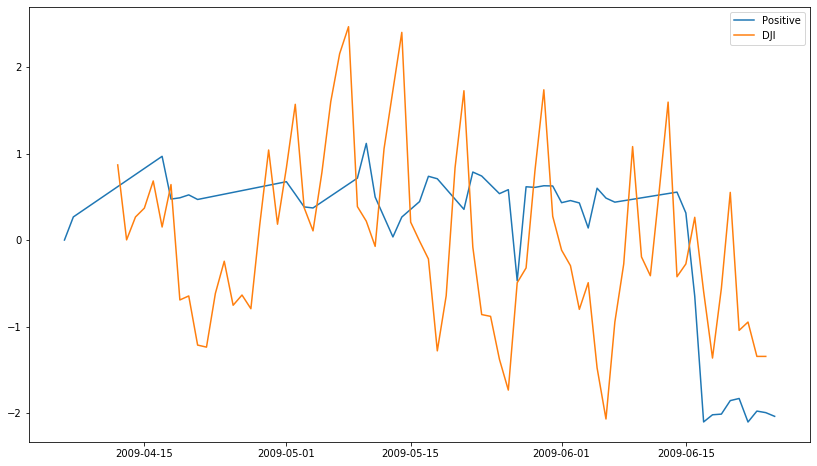

In [124]:
import matplotlib

plt.figure(figsize=(14,8))
plt.plot(df['date'], df['positive'], label='Positive')
# plt.plot(df['date'], df['neutral'], label='Neutral')
# plt.plot(df['date'], df['negative'], label='Negative')
plt.plot(dji['Date'], dji['ADX_4_4'], label='DJI')
# plt.plot(dji_old['Date'], dji_old['ADX_4_4'], label='DJI_old')
plt.legend();

## What If I don't Average over day and just scale? 

In [125]:
df_summed = df_summed.drop(columns=['total_score'])

In [126]:
# df_summed[]
df_summed[cols] = scaler.fit_transform(df_summed[cols])

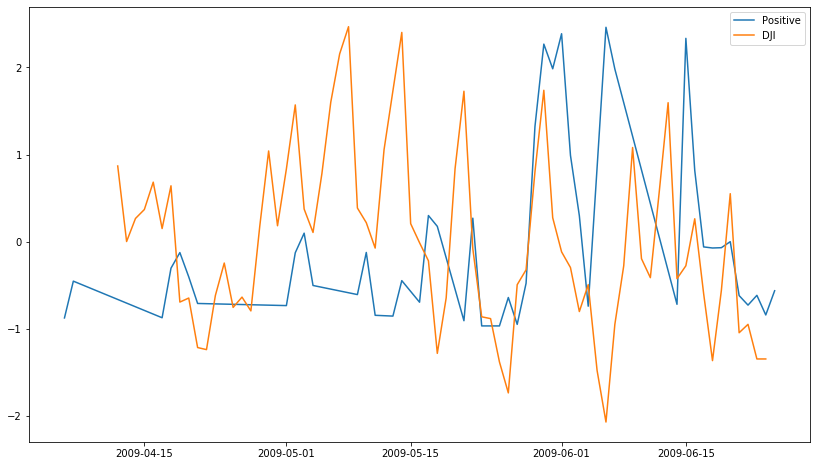

In [127]:
plt.figure(figsize=(14,8))
plt.plot(df_summed['date'], df_summed['positive'], label='Positive')
# plt.plot(df_summed['date'], df_summed['neutral'], label='Neutral')
# plt.plot(df_summed['date'], df_summed['negative'], label='Negative')
plt.plot(dji['Date'], dji['ADX_4_4'], label='DJI')
plt.legend();

**Interpretation:** Definately seems to be some similar trends here, although the magnitude is quite different. I'm interested in what happened when both lines contradict each other.

In [34]:
df_summed['date'] = pd.to_datetime(df_summed['date'])

In [35]:
df_summed.dtypes

date        datetime64[ns]
negative           float64
neutral            float64
positive           float64
dtype: object

In [36]:
from datetime import datetime
df_trim = df_summed[df_summed['date'] > datetime(2009,6,4)]
dji_trim = dji[dji['Date'] > datetime(2009,6,4)]

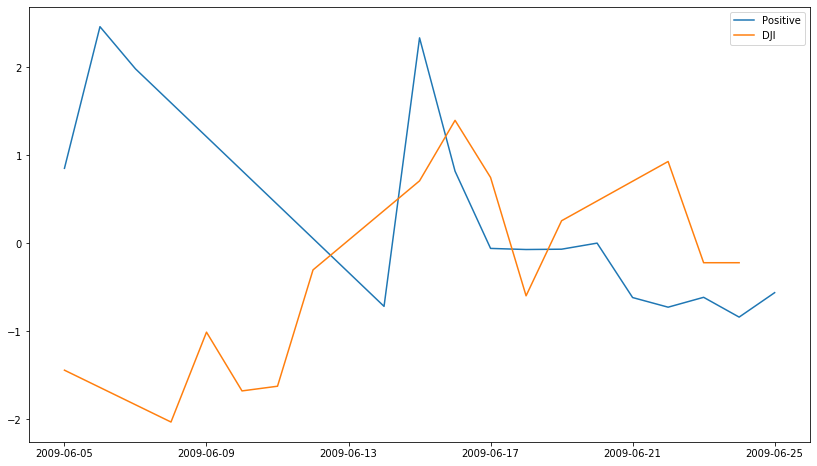

In [37]:
plt.figure(figsize=(14,8))
plt.plot(df_trim['date'], df_trim['positive'], label='Positive')
# plt.plot(df_summed['date'], df_summed['neutral'], label='Neutral')
# plt.plot(df_summed['date'], df_summed['negative'], label='Negative')
plt.plot(dji_trim['Date'], dji_trim['ADX_4_4'], label='DJI')
plt.legend();

In [38]:
### small window of tweets between 
mask = (df_summed['date'] > datetime(2009,6,4)) & (df_summed['date'] < datetime(2009,6,6))
df_trim = df_summed[mask]

## Looking back at the tweets 

In [41]:
df_text = pd.read_pickle('./final_tweets.pickle')

df_text['date'] = pd.to_datetime(df_text['date'])
mask = (
    df_text['date'] > datetime(2009,6,4)) & (df_text['date'] < datetime(2009,6,6)) & (df_text['positive'] == 1)
df_text = df_text[mask]

## Spacy Entity Recognition 

In [42]:
import spacy

In [43]:
# spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm")

In [ ]:
count = 0
for tweet in df_text.text:
    doc = nlp(tweet)
    count +=1
    for ent in doc.ents:
#         print(ent.label_)
        if ent.label_ == 'WORK_OF_ART' or ent.label == 'PERSON':
            print(ent.text)
#     if count == 20:
#         break